<a href="https://colab.research.google.com/github/chenyu313/TensorFlow-note/blob/main/1_%E4%BD%BF%E7%94%A8RNN%E7%94%9F%E6%88%90%E6%96%87%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Text generation with an RNN
将使用Andrej Karpathy的《循环神经网络的不可思议的有效性》中的莎士比亚（Shakespeare）作品数据集。给定来自该数据的字符序列(“Shakespear”)，训练一个模型来预测序列中的下一个字符(“e”)。通过反复调用模型可以生成更长的文本序列。

虽然有些句子合乎语法，但大多数都没有意义。模型没有学习单词的意思，但是考虑:
* 该模型是基于字符的。当训练开始时，模型不知道如何拼写英语单词，甚至不知道单词是文本的一个单位。
* 输出的结构类似于一个积木块，文本块通常以说话人的名字开头，所有的大写字母与数据集相似。
* 如下所示，该模型在小批量文本(每个文本100个字符)上进行训练，并且仍然能够生成具有连贯结构的更长的文本序列。

### 配置


In [2]:
import tensorflow as tf

import numpy as np
import os
import time

### 下载莎士比亚数据集


In [3]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

1115394/1115394 [==============================] - 0s 0us/step


### 阅读数据


In [4]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


In [5]:
# 查看前250个字符
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [6]:
# 文件中唯一的字符（将text装入set中，相当于计数文本中一共有多少个词（去重））
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

65 unique characters


### 处理数据

#### 向量化文本
在训练之前，您需要将字符串转换为数字表示形式。
 tf.keras.layers.StringLookup层可以将每个字符转换为数字ID。它只需要首先将文本拆分为标记。

In [7]:
example_texts = ['abcdefg', 'xyz']

chars = tf.strings.unicode_split(example_texts, input_encoding='UTF-8')
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [8]:
# 现在创建tf.keras.layers.StringLookup层:
ids_from_chars = tf.keras.layers.StringLookup(
    vocabulary=list(vocab), mask_token=None)

它将tokens转换为字符id:

In [9]:
ids = ids_from_chars(chars)
ids

<tf.RaggedTensor [[40, 41, 42, 43, 44, 45, 46], [63, 64, 65]]>

由于本教程的目标是生成文本，因此颠倒这种表示并从中恢复人类可读的字符串也很重要。为此，你可以使用tf.keras.layers.StringLookup(…,invert=True)。

In [10]:
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

In [11]:
# 从id转变为字符
chars = chars_from_ids(ids)
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

你可以使用tf.strings.reduce_join将字符连接回字符串。

In [12]:
tf.strings.reduce_join(chars, axis=-1).numpy()

array([b'abcdefg', b'xyz'], dtype=object)

In [13]:
def text_from_ids(ids):
  return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

#### 预测任务
给定一个字符，或一个字符序列，下一个最可能的字符是什么?这就是你训练模型执行的任务。模型的输入将是一个字符序列，您训练模型来预测输出——在每个时间步上的以下字符。

由于rnn维持一种依赖于先前看到的元素的内部状态，给定到目前为止计算的所有字符，下一个字符是什么?

#### 创建训练实例和目标
接下来将文本划分为示例序列。每个输入序列将包含来自文本的seq_length字符。

对于每个输入序列，对应的目标包含相同长度的文本，只是向右移动了一个字符。

所以将文本分成seq_length+1的块。例如，假设seq_length为4，我们的文本为“Hello”。输入序列是“Hell”，目标序列是“ello”。

要做到这一点，首先使用tf.data.Dataset.from_tensor_slices函数将文本向量转换为字符索引流。

In [14]:
# 将字符转化为ids
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19, 48, 57, ..., 46,  9,  1])>

In [15]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [16]:
for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

F
i
r
s
t
 
C
i
t
i


In [17]:
seq_length = 100

批处理方法允许您轻松地将这些单个字符转换为所需大小的序列。

In [18]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


将tokens连接回字符串，则更容易看到这是在做什么:

In [19]:
for seq in sequences.take(5):
  print(text_from_ids(seq).numpy())

b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
b"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
b'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


对于训练，你需要一个(输入，标签)对的数据集。其中input和label是序列。在每个时间步，输入是当前字符，标签是下一个字符。

下面是一个函数，它将一个序列作为输入，复制并移动它以使每个时间步的输入和标签对齐:

In [20]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [21]:
# 相当于给你“Tensorflo"，让你预测“ensorflow"
split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [22]:
dataset = sequences.map(split_input_target)

for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy()) #这里后面是一个空格

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


#### 创建训练批次
使用用了tf.data将文本分割成可管理的序列的数据。但是，在将这些数据输入模型之前，您需要对数据进行洗牌并将其打包成批。

In [23]:
# Batch size
BATCH_SIZE = 64

# 打乱数据集的缓冲区大小
# (TF数据被设计用于处理可能无限的序列，因此它不会试图打乱内存中的整个序列。相反，它维护一个缓冲区，在其中对元素进行洗牌).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

### 建模
这个模型有三层:
* tf.keras.layers.Embedding: 输入层。一个可训练的查找表，将每个字符id映射到具有embedding_dim维度的向量;
* tf.keras.layers.GRU: 一种大小单位=rnn_units的RNN(你也可以在这里使用LSTM层)。
* tf.keras.layers.Dense: 输出层，输出为vocab_size。它为词汇表中的每个字符输出一个logit。根据模型，这些是每个字符的对数似然。

In [24]:
# StringLookup层中词汇表的长度
vocab_size = len(ids_from_chars.get_vocabulary())

# 嵌入维数
embedding_dim = 256

# RNN单元的数量
rnn_units = 1024

In [25]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                    return_sequences=True,
                    return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [26]:
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

对于每个字符，模型查找嵌入，以嵌入作为输入运行GRU一个时间步，并应用密集层生成预测下一个字符的对数似然的logits:

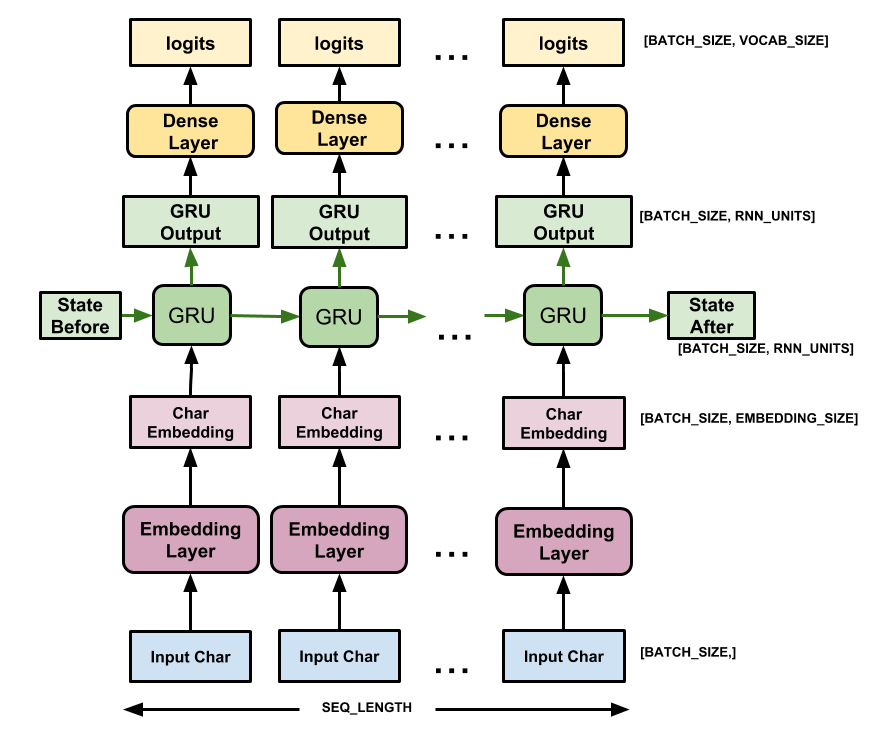

现在运行模型，看看它的行为是否符合预期。

首先检查输出的形状:

In [27]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 66) # (batch_size, sequence_length, vocab_size)


In [28]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  16896     
                                                                 
 gru (GRU)                   multiple                  3938304   
                                                                 
 dense (Dense)               multiple                  67650     
                                                                 
Total params: 4,022,850
Trainable params: 4,022,850
Non-trainable params: 0
_________________________________________________________________


为了从模型中获得实际的预测，您需要从输出分布中采样，以获得实际的字符索引。这种分布是由字符词汇表上的logits定义的。

注意:从这个分布中抽样很重要，因为取分布的argmax很容易使模型陷入循环。

In [29]:
# 处理一个例子尝试一下
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

In [30]:
# 在每个时间步，这将为我们提供下一个字符索引的预测:
sampled_indices

array([16, 44, 19, 33, 21,  6, 61, 38, 20, 24, 55,  0, 35, 32, 51, 29,  5,
       19, 41, 57, 21, 56, 63, 56, 47, 55, 53, 64, 53, 64, 57, 33, 48, 12,
        2, 21,  0, 10, 23, 39, 10,  8,  8, 33, 64, 63, 62, 37, 34,  8, 11,
       35, 64, 43, 48, 18, 32, 60, 58, 14, 44, 51,  3, 25, 40, 47, 33, 22,
       58, 57, 42, 57, 37, 29,  5, 60, 21, 28, 10, 43, 25, 30, 59, 23, 13,
       40, 40, 61, 50,  2, 12,  9,  2, 38, 42, 20, 36, 21, 24,  3])

解码这些，看看这个未经训练的模型预测的文本:

In [31]:
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

Input:
 b"\nBut stay thee, 'tis the fruits of love I mean.\n\nLADY GREY:\nThe fruits of love I mean, my loving lie"

Next Char Predictions:
 b"CeFTH'vYGKp[UNK]VSlP&FbrHqxqhpnynyrTi; H[UNK]3JZ3--TyxwXU-:VydiESusAel!LahTIsrcrXP&uHO3dLQtJ?aavk ;. YcGWHK!"


### 训练模型
在这一点上，这个问题可以被视为一个标准的分类问题。给定之前的RNN状态，以及这个时间步长的输入，预测下一个字符的类别。



In [32]:
# 稀疏交叉分类损失
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [33]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 100, 66)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.1890483, shape=(), dtype=float32)


新初始化的模型不应该太确定自己，输出逻辑值应该都有相似的大小。为了证实这一点，您可以检查平均损失的指数是否近似等于词汇量大小。更高的损失意味着模型确定其错误的答案，并且初始化很糟糕:

In [34]:
tf.exp(example_batch_mean_loss).numpy()

65.959984

使用tf.keras.Model.compile方法配置训练过程。使用带有默认参数和损失函数的tf.keras.optimizers.Adam。

In [35]:
model.compile(optimizer='adam', loss=loss)

#### 配置检查点
使用tf.keras.callback . modelcheckpoint来确保在训练期间保存检查点:

In [36]:
# 将保存检查点的目录
checkpoint_dir = './training_checkpoints'
# 检查点文件的名称
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

#### 开始训练


In [37]:
EPOCHS = 20

history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/20
172/172 [==============================] - 15s 58ms/step - loss: 2.7277
Epoch 2/20
172/172 [==============================] - 11s 54ms/step - loss: 1.9996
Epoch 3/20
172/172 [==============================] - 11s 55ms/step - loss: 1.7157
Epoch 4/20
172/172 [==============================] - 14s 56ms/step - loss: 1.5527
Epoch 5/20
172/172 [==============================] - 12s 55ms/step - loss: 1.4528
Epoch 6/20
172/172 [==============================] - 12s 56ms/step - loss: 1.3842
Epoch 7/20
172/172 [==============================] - 12s 56ms/step - loss: 1.3310
Epoch 8/20
172/172 [==============================] - 12s 56ms/step - loss: 1.2848
Epoch 9/20
172/172 [==============================] - 12s 57ms/step - loss: 1.2432
Epoch 10/20
172/172 [==============================] - 13s 58ms/step - loss: 1.2035
Epoch 11/20
172/172 [==============================] - 12s 57ms/step - loss: 1.1628
Epoch 12/20
172/172 [==============================] - 12s 57ms/step - loss: 1.1216
E

### 生成文本
使用该模型生成文本的最简单方法是在循环中运行它，并在执行时跟踪模型的内部状态。
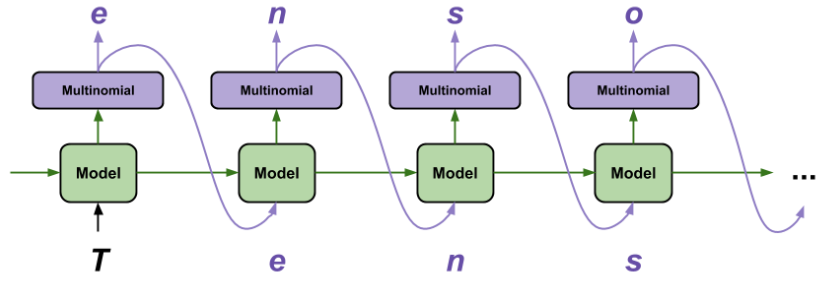

每次调用模型时，都会传入一些文本和一个内部状态。该模型返回下一个字符及其新状态的预测。将预测和状态传回以继续生成文本。

下面做一个单步预测:

In [38]:
class OneStep(tf.keras.Model):
  # 单步预测
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # 创建一个掩码以防止“[UNK]”生成。
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # 在每个不好的索引上加一个-inf。
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # 将形状与词汇相匹配
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # 将字符串转换为令牌id。
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # 运行模型
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                        return_state=True)
    # 只使用最后的预测。
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # 应用预测掩码:防止“[UNK]”生成。
    predicted_logits = predicted_logits + self.prediction_mask

    # 对输出日志进行采样以生成token id。
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # 将令牌id转换为字符
    predicted_chars = self.chars_from_ids(predicted_ids)

    # 返回字符和模型状态。
    return predicted_chars, states

In [39]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

在循环中运行它以生成一些文本。查看生成的文本，您将看到该模型知道何时大写、撰写段落并模仿莎士比亚式的写作词汇。由于训练次数少，它还没有学会形成连贯的句子。

In [44]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

ROMEO:
The eldest wake a worse than I must wrong
Henceforthy I am out--but for it.

ADGID:
He hath a harver seas' that apply-tain it and
By revenue and death shall breed ones.
But such a case is the dost of these sad stirring!
But when he pitites calls out of it.
Mistake me not, I must have spoken from such grace,
To give me from Dull of Buckingham to thee,
The next give way that subfuble from the virgin post
Should, said that hath a pedlar: though it be dissiden.

KING RICHARD III:
If, Tybalt, trunce! But, speak!
I am a wish, was return to you.

ANGELO:
See where we would entreat brings the ungent our teddoman,
or like a counterfeit bawd. Give me the banks
Which 'twas he entertain'd thy poverty,
And many slaughter with your heart wept nor less hand,
Though 'tis thus can he lies.

SEBASTIAN:
No; for I am ready to lendy heart.
Thus plucks high thoughts, not took her past
And chamber appear'd. Come, sirrah yourself
I tell yea, and I will pardon me and
Of this vice buck and leave their wa

你能做的最简单的事情就是延长训练时间(试试EPOCHS = 30)。

您还可以尝试使用不同的起始字符串，尝试添加另一个RNN层以提高模型的准确性，或者调整温度参数以生成或多或少随机的预测。

如果您希望模型更快地生成文本，您可以做的最简单的事情就是批量生成文本。在下面的例子中，模型生成5个输出的时间与上面生成1个输出的时间大致相同。

In [48]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result, '\n\n' + '_'*80)
print('\nRun time:', end - start)

tf.Tensor(
[b"ROMEO:\nThese lands all taunts in below his hands\nWhich he shall find like galland, like a nuked\nYou will revenge it still upon him.--Low in the curses,\nWhose hand shed want her kindness and his last,\nAnd 'twere to do myself to but myssilt end:\nRemember judgment, scarce any journain of mine,\nWhen, ere they, in the axeling part not this cofflows in the flinty\nAs if her eye-bell ere the city I have in him.\nBut I shall love My lord,\nMust get upon my brother.\n\nMIRANDA:\nO my poor Margaret, and perish!\nThus, if thou say the King of Buckingham, battlew must\nForsook her; but on the way\nI was from the visage of ten thousand,\nNothing pups sworms, and express come neaven\nmuch to death, and her burpher blush in earth.\n\nFRIAR LAURENCE:\nSo chose this odds be, let no great Apollo's ward.\nWhat, is there some sword, and do contest the earth?\nWhy, this shall see, the title will be tempted to oxenswife's angers\nNearved fruitful visition well,\nThat thought to beat do 

### 导出生成器
这个单步模型可以很容易地保存和恢复，tf.saved_model允许您在任何地方使用它。

In [49]:
tf.saved_model.save(one_step_model, 'one_step')
one_step_reloaded = tf.saved_model.load('one_step')

In [50]:
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(100):
  next_char, states = one_step_reloaded.generate_one_step(next_char, states=states)
  result.append(next_char)

print(tf.strings.join(result)[0].numpy().decode("utf-8"))

ROMEO:
These lips must behold me again,
When mightish taughs her ears to stalve him; for her well her sain


### 高级：定制训练
上面的训练程序很简单，但并没有给你太多的控制权。它使用教师强制来防止错误的预测反馈到模型中，因此模型永远不会学会从错误中恢复过来。

现在您已经看到了如何手动运行模型，接下来您将实现训练循环。例如，如果您希望实现课程学习以帮助稳定模型的开环输出，那么这提供了一个起点。

自定义训练循环中最重要的部分是训练阶跃函数。

使用tf.GradientTape跟踪梯度。

基本程序如下：
* 执行模型并计算在tf.GradientTape下的损耗。
* 计算更新并使用优化器将其应用于模型。

In [51]:
class CustomTraining(MyModel):
  @tf.function
  def train_step(self, inputs):
      inputs, labels = inputs
      with tf.GradientTape() as tape:
          predictions = self(inputs, training=True)
          loss = self.loss(labels, predictions)
      grads = tape.gradient(loss, model.trainable_variables)
      self.optimizer.apply_gradients(zip(grads, model.trainable_variables))

      return {'loss': loss}

In [53]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
       loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

In [54]:
model.fit(dataset, epochs=1)

172/172 [==============================] - 14s 59ms/step - loss: 0.6559


In [55]:
EPOCHS = 10

mean = tf.metrics.Mean()

for epoch in range(EPOCHS):
    start = time.time()

    mean.reset_states()
    for (batch_n, (inp, target)) in enumerate(dataset):
        logs = model.train_step([inp, target])
        mean.update_state(logs['loss'])

        if batch_n % 50 == 0:
            template = f"Epoch {epoch+1} Batch {batch_n} Loss {logs['loss']:.4f}"
            print(template)

    # saving (checkpoint) the model every 5 epochs
    if (epoch + 1) % 5 == 0:
        model.save_weights(checkpoint_prefix.format(epoch=epoch))

    print()
    print(f'Epoch {epoch+1} Loss: {mean.result().numpy():.4f}')
    print(f'Time taken for 1 epoch {time.time() - start:.2f} sec')
    print("_"*80)

model.save_weights(checkpoint_prefix.format(epoch=epoch))

Epoch 1 Batch 0 Loss 0.6552
Epoch 1 Batch 50 Loss 0.6324
Epoch 1 Batch 100 Loss 0.6237
Epoch 1 Batch 150 Loss 0.6226

Epoch 1 Loss: 0.6299
Time taken for 1 epoch 15.64 sec
________________________________________________________________________________
Epoch 2 Batch 0 Loss 0.6232
Epoch 2 Batch 50 Loss 0.6093
Epoch 2 Batch 100 Loss 0.6023
Epoch 2 Batch 150 Loss 0.6003

Epoch 2 Loss: 0.6065
Time taken for 1 epoch 12.80 sec
________________________________________________________________________________
Epoch 3 Batch 0 Loss 0.6002
Epoch 3 Batch 50 Loss 0.5901
Epoch 3 Batch 100 Loss 0.5839
Epoch 3 Batch 150 Loss 0.5815

Epoch 3 Loss: 0.5872
Time taken for 1 epoch 13.45 sec
________________________________________________________________________________
Epoch 4 Batch 0 Loss 0.5813
Epoch 4 Batch 50 Loss 0.5736
Epoch 4 Batch 100 Loss 0.5682
Epoch 4 Batch 150 Loss 0.5660

Epoch 4 Loss: 0.5709
Time taken for 1 epoch 20.47 sec
_____________________________________________________________________

参考： https://www.tensorflow.org/text/tutorials/text_generation